# Exploring COVID-19 numbers: the data acquisition process

### Environment log:

(1) Using the "analytics3" anaconda environment; installing python packages directly through *pip* command.  
(2) Installed *pyvirtualenv*, *selenium*, and *[bs4](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#)* packages.  
(3) Installed *chromedriver* through "pip install chromedriver".  

(4) Got this error when initializing the Display function:
> display = Display(visible=0, size=(800,600))
> display.start()  
>> FileNotFoundError: [Errno 2] No such file or directory: 'Xvfb': 'Xvfb'
>> EasyProcessError: start error EasyProcess cmd_param=['Xvfb', '-help'] cmd=['Xvfb', '-help'] oserror=[Errno 2] No such file or directory: 'Xvfb': 'Xvfb' return_code=None stdout="None" stderr="None" timeout_happened=False>

**Solution found in: https://bugs.debian.org/cgi-bin/bugreport.cgi?bug=860501**   
 
(5) Installed the system package xvfb through the shell line: *sudo apt-get install xvfb*.

- When running the "driver = webdriver.Chrome()" python command, I received the following error:  
> driver = webdriver.Chrome()
>> FileNotFoundError: [Errno 2] No such file or directory: 'chromedriver': 'chromedriver'  

(6) Even though, since I'm using conda environment I have set the chromedriver path before:  
> chromeDriverPath = '~/anaconda3/envs/analytics3/'

The solution was to create a symbolic link in the path shown above, through the system bash, which made it work properly:  
> $ ln -s ~/anaconda3/envs/analytics3/chromedriver-Linux64 chromedriver  

(7) There are some broken links in the BMH oficial page: it misses the "https://portalarquivos.saude.gov.br/" portion of the link. We defined a function to address this issue.


## Epidemiological bulletins from World Health Organization - WHO
https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/  
https://github.com/danielsteman/COVID-19_WHO  
https://github.com/danielsteman/COVID-19_WHO/blob/master/WHO_webscrape.ipynb (the author uses PyPDF2)

## Epidemiological bulletins from Brazilian Ministry of Health
https://www.saude.gov.br/boletins-epidemiologicos
  - Coronavírus/COVID-19  
  - Dengue

## COVID-19 pandemic: official dashboard of the Ministry of Health of Brazil
https://covid.saude.gov.br/

### Initial statements

In [1]:
import sys
print(sys.version)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [2]:
from pyvirtualdisplay import Display
from selenium import webdriver

## BeautifulSoup - BeautifulSoup is not needed at this time, since there's no parsing.
#from bs4 import 

In [3]:
# Definição de parâmetros
url = 'https://covid.saude.gov.br'
chromeDriverPath = '/home/tbnsilveira/anaconda3/envs/analytics/chromedriver'

### Web browsing

In this step of our data crawling we want to access the webpage through the Chromium driver. It is then appropriate to create some functions both for the page access as for its content analysis. However, it would be only possible if we know the page structure. In order to reach it, at this time we will try to read and explore it, trying to find the patterns and links we are looking for.

In [4]:
# Display starting:
display = Display(visible=0, size=(800,600))
display.start()

In [5]:
# Open the Chromium.driver for the intended page:
driver = webdriver.Chrome(chromeDriverPath)

In [6]:
# Reading the page content and saving it specifying its encoding scheme:
driver.get(url)
page = driver.page_source.encode('utf-8')

### Initial exploration

In [7]:
# How large is the loaded page?
print(len(page))
# Data streaming type is expected:
print(type(page))

112616
<class 'bytes'>


In [9]:
## Showing only the first 2k positions of the bytes stream:
print(page[:2000])

b'<!DOCTYPE html><html xmlns="http://www.w3.org/1999/xhtml" lang="en" class="plt-phablet plt-desktop md hydrated" mode="md"><head>\n    <meta charset="utf-8" /><style data-styles="">ion-select-popover,ion-select,ion-select-option,ion-menu-button,ion-menu,ion-menu-toggle,ion-action-sheet,ion-fab-button,ion-fab,ion-fab-list,ion-refresher-content,ion-refresher,ion-back-button,ion-backdrop,ion-alert,ion-loading,ion-toast,ion-card,ion-card-content,ion-card-header,ion-card-subtitle,ion-card-title,ion-item-option,ion-item-options,ion-item-sliding,ion-infinite-scroll-content,ion-infinite-scroll,ion-reorder,ion-reorder-group,ion-segment-button,ion-segment,ion-tab-button,ion-tab-bar,ion-chip,ion-modal,ion-popover,ion-searchbar,ion-app,ion-buttons,ion-content,ion-footer,ion-header,ion-router-outlet,ion-title,ion-toolbar,ion-route,ion-route-redirect,ion-router,ion-router-link,ion-avatar,ion-badge,ion-thumbnail,ion-col,ion-grid,ion-row,ion-nav,ion-nav-link,ion-slide,ion-slides,ion-checkbox,ion-img,

------------------

Once the website is loaded, **BeautifulSoup is typically used to mine its content and explore links of interest**. In this case, however, **the new portal made available by BMH was created in Firebase**. That is, there is no link to the database, but a response to the action of clicking the button.

Using Chrome's inspection tool, we can locate the element related to downloading the data and then emulate its click through the Selenium library.

In [10]:
## Path of the element from Chrome inspection tool:
xpathElement = '/html/body/app-root/ion-app/ion-router-outlet/app-home/ion-content/div[1]/div[2]/ion-button'

## Element corresponding to "Arquivo CSV" button:
dataDownloader = driver.find_element_by_xpath(xpathElement)

In [11]:
dataDownloader.click()

The steps above allowed us to download the CSV file to the default downloading directory. An open issue from this script is to set the specific file destiny. There are some references saying Selenium does not support dialogue boxes. Other references explore ways to do it out:

https://medium.com/@moungpeter/how-to-automate-downloading-files-using-python-selenium-and-headless-chrome-9014f0cdd196

---------------------

### Reading the downloaded CSV file:

In [12]:
import os
import glob

To figure out how to select the last downloaded file in a directory, I used the code available in https://stackoverflow.com/questions/39327032/how-to-get-the-latest-file-in-a-folder-using-python.

In [13]:
## Picking the last XLSX downloaded file:
list_of_files = glob.glob('/home/tbnsilveira/Downloads/*.xlsx') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)

/home/tbnsilveira/Downloads/HIST_PAINEL_COVIDBR_31mai2020 (1).xlsx


In [70]:
latest_file = list_of_files[2]
latest_file

'/home/tbnsilveira/Downloads/HIST_PAINEL_COVIDBR_20mai2020 (2).xlsx'

In [14]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [45]:
covidData = pd.read_excel(latest_file)

In [46]:
covidData

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
0,Brasil,NaN,NaN,76.0,NaN,NaN,NaN,2020-02-26,9.0,210147125.0,1.0,0.0,0.0,0.0,NaN,NaN
1,Brasil,NaN,NaN,76.0,NaN,NaN,NaN,2020-02-27,9.0,210147125.0,1.0,0.0,0.0,0.0,NaN,NaN
2,Brasil,NaN,NaN,76.0,NaN,NaN,NaN,2020-02-28,9.0,210147125.0,1.0,0.0,0.0,0.0,NaN,NaN
3,Brasil,NaN,NaN,76.0,NaN,NaN,NaN,2020-02-29,9.0,210147125.0,2.0,1.0,0.0,0.0,NaN,NaN
4,Brasil,NaN,NaN,76.0,NaN,NaN,NaN,2020-03-01,10.0,210147125.0,2.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138766,Sul,RS,NaN,43.0,NaN,NaN,NaN,2020-05-30,22.0,11377239.0,9242.0,1008.0,218.0,5.0,NaN,NaN
138767,Centro-Oeste,MS,NaN,50.0,NaN,NaN,NaN,2020-05-30,22.0,2778986.0,1418.0,62.0,19.0,1.0,NaN,NaN
138768,Centro-Oeste,MT,NaN,51.0,NaN,NaN,NaN,2020-05-30,22.0,3484466.0,2361.0,258.0,57.0,1.0,NaN,NaN
138769,Centro-Oeste,GO,NaN,52.0,NaN,NaN,NaN,2020-05-30,22.0,7018354.0,3585.0,266.0,122.0,3.0,NaN,NaN


-----------------

In the way this script was initialy built, it was important to remove the CSV file after reading it, thus preventing the most current versions from being downloaded under another name. However, in the second week of May, the BMH changed the file format to XLSX, thus requiring to adapt the script. In this case, I choose to read the last downloaded file, then keeping all the copies in my system. In the case you don't want these copies, you can just uncomment the line below:

In [47]:
## In some situations you'll have to replace "~/" by the full local address (/home/user...)
#os.remove(latest_file)

------------------

## Data wrangling 

In [51]:
covidData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138771 entries, 0 to 138770
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   regiao                 138733 non-null  object 
 1   estado                 138636 non-null  object 
 2   municipio              135796 non-null  object 
 3   coduf                  138733 non-null  float64
 4   codmun                 136470 non-null  float64
 5   codRegiaoSaude         135796 non-null  float64
 6   nomeRegiaoSaude        135796 non-null  object 
 7   data                   138733 non-null  object 
 8   semanaEpi              138733 non-null  float64
 9   populacaoTCU2019       138059 non-null  float64
 10  casosAcumulado         138733 non-null  float64
 11  casosNovos             138733 non-null  float64
 12  obitosAcumulado        138733 non-null  float64
 13  obitosNovos            138733 non-null  float64
 14  Recuperadosnovos       44 non-null  

### Adjusting the datetime type data:

From the information above, there are 38 instances with null value. First we must check which kind of data are in these lines, then deciding if will remove them or not.

In [49]:
### Which datetype data is null?
covidData[covidData.data.isnull()]

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
4180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
covidData.loc[4176:4182]

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
4176,Centro-Oeste,GO,Urutaí,52.0,522180.0,52005.0,Estrada de Ferro,2020-05-30,23.0,3072.0,2.0,0.0,0.0,0.0,NaN,NaN
4177,Centro-Oeste,GO,Valparaíso de Goiás,52.0,522185.0,52004.0,Entorno Sul,2020-05-30,23.0,168468.0,118.0,0.0,2.0,0.0,NaN,NaN
4178,Centro-Oeste,GO,Vianópolis,52.0,522200.0,52002.0,Centro Sul,2020-05-30,23.0,13863.0,1.0,0.0,0.0,0.0,NaN,NaN
4179,Centro-Oeste,DF,Brasília,53.0,530010.0,53001.0,Brasília,2020-05-30,23.0,3015268.0,9474.0,0.0,162.0,0.0,NaN,NaN
4180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Dropping the NaN values:

In [129]:
covidData2 = covidData.copy()

In [130]:
covidData2.dropna(axis=0, subset=['data'], inplace=True)

In [131]:
covidData2.reset_index(drop=True, inplace=True)

In [132]:
covidData2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138733 entries, 0 to 138732
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   regiao                 138733 non-null  object 
 1   estado                 138636 non-null  object 
 2   municipio              135796 non-null  object 
 3   coduf                  138733 non-null  float64
 4   codmun                 136470 non-null  float64
 5   codRegiaoSaude         135796 non-null  float64
 6   nomeRegiaoSaude        135796 non-null  object 
 7   data                   138733 non-null  object 
 8   semanaEpi              138733 non-null  float64
 9   populacaoTCU2019       138059 non-null  float64
 10  casosAcumulado         138733 non-null  float64
 11  casosNovos             138733 non-null  float64
 12  obitosAcumulado        138733 non-null  float64
 13  obitosNovos            138733 non-null  float64
 14  Recuperadosnovos       44 non-null  

--------------------------

#### Setting the datetime64 type to the "Date" column (it's called "data" in Portuguese):

In [133]:
type(covidData2.data)

pandas.core.series.Series

In [134]:
type(covidData2.data[2])

str

In [135]:
covidData2.data = covidData2.data.astype('datetime64')

-----------------

## Visualizing some data:

In [136]:
covidData2

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
0,Brasil,NaN,NaN,76.0,NaN,NaN,NaN,2020-02-26,9.0,210147125.0,1.0,0.0,0.0,0.0,NaN,NaN
1,Brasil,NaN,NaN,76.0,NaN,NaN,NaN,2020-02-27,9.0,210147125.0,1.0,0.0,0.0,0.0,NaN,NaN
2,Brasil,NaN,NaN,76.0,NaN,NaN,NaN,2020-02-28,9.0,210147125.0,1.0,0.0,0.0,0.0,NaN,NaN
3,Brasil,NaN,NaN,76.0,NaN,NaN,NaN,2020-02-29,9.0,210147125.0,2.0,1.0,0.0,0.0,NaN,NaN
4,Brasil,NaN,NaN,76.0,NaN,NaN,NaN,2020-03-01,10.0,210147125.0,2.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138728,Sul,RS,NaN,43.0,NaN,NaN,NaN,2020-05-30,22.0,11377239.0,9242.0,1008.0,218.0,5.0,NaN,NaN
138729,Centro-Oeste,MS,NaN,50.0,NaN,NaN,NaN,2020-05-30,22.0,2778986.0,1418.0,62.0,19.0,1.0,NaN,NaN
138730,Centro-Oeste,MT,NaN,51.0,NaN,NaN,NaN,2020-05-30,22.0,3484466.0,2361.0,258.0,57.0,1.0,NaN,NaN
138731,Centro-Oeste,GO,NaN,52.0,NaN,NaN,NaN,2020-05-30,22.0,7018354.0,3585.0,266.0,122.0,3.0,NaN,NaN


In [137]:
## Showing the line with the highest number of deaths:
idx = covidData2.obitosAcumulado.idxmax()
covidData2.iloc[idx]

regiao                                Brasil
estado                                   NaN
municipio                                NaN
coduf                                     76
codmun                                   NaN
codRegiaoSaude                           NaN
nomeRegiaoSaude                          NaN
data                     2020-05-31 00:00:00
semanaEpi                                 23
populacaoTCU2019                 2.10147e+08
casosAcumulado                        514849
casosNovos                             16409
obitosAcumulado                        29314
obitosNovos                              480
Recuperadosnovos                      206555
emAcompanhamentoNovos                 278980
Name: 4181, dtype: object

----------

#### Exploring only SC municipalities

In [138]:
covid_SC = covidData2[covidData2.estado == 'SC']

In [124]:
covid_SC.municipio.unique()

array([nan, 'Abdon Batista', 'Abelardo Luz', 'Agrolândia', 'Agronômica',
       'Água Doce', 'Águas de Chapecó', 'Águas Frias', 'Águas Mornas',
       'Alto Bela Vista', 'Anchieta', 'Anita Garibaldi', 'Antônio Carlos',
       'Arabutã', 'Araquari', 'Araranguá', 'Armazém', 'Arvoredo',
       'Ascurra', 'Atalanta', 'Aurora', 'Balneário Arroio do Silva',
       'Balneário Camboriú', 'Balneário Barra do Sul',
       'Balneário Gaivota', 'Barra Velha', 'Benedito Novo', 'Biguaçu',
       'Blumenau', 'Bombinhas', 'Botuverá', 'Braço do Norte', 'Brusque',
       'Caçador', 'Caibi', 'Camboriú', 'Campo Erê', 'Campos Novos',
       'Canelinha', 'Canoinhas', 'Capinzal', 'Capivari de Baixo',
       'Catanduvas', 'Caxambu do Sul', 'Chapecó', 'Cocal do Sul',
       'Concórdia', 'Cordilheira Alta', 'Coronel Freitas', 'Corupá',
       'Criciúma', 'Cunha Porã', 'Curitibanos', 'Descanso',
       'Dionísio Cerqueira', 'Entre Rios', 'Faxinal dos Guedes',
       'Florianópolis', 'Forquilhinha', 'Fraiburgo', 

In [139]:
sns.set_style("whitegrid")

In [140]:
cidade = 'Florianópolis'

Text(0.5, 1.0, 'Número de casos COVID-19 acumulados em Florianópolis, SC, em 21/05/2020')

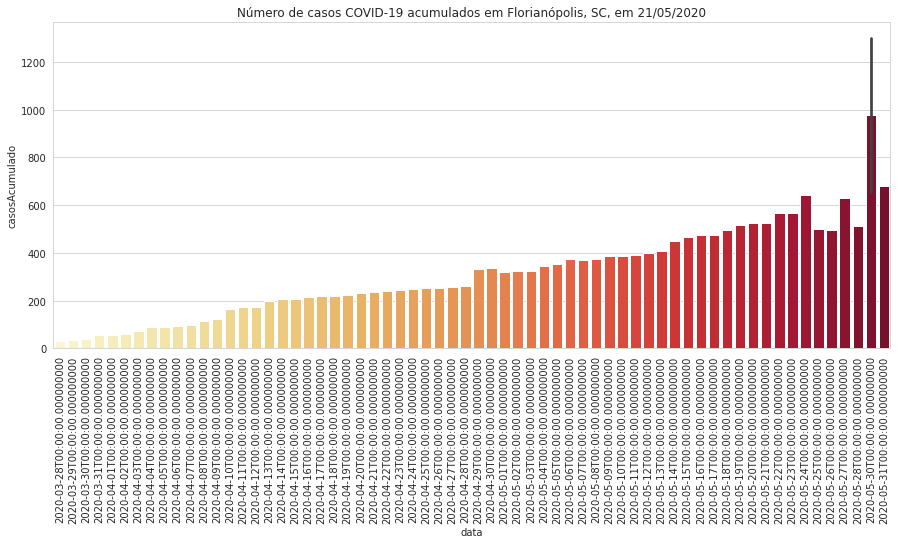

In [141]:
fig, ax = plt.subplots(figsize=(15,6))

ax = sns.barplot(x='data', y='casosAcumulado', data=covid_SC[covid_SC['municipio'] == cidade], palette='YlOrRd')
plt.xticks(rotation='vertical');
plt.title('Número de casos COVID-19 acumulados em {0}, SC, em 21/05/2020'.format(cidade))

In [142]:
covid_SC[covid_SC['municipio'] == 'Blumenau']

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos
3436,Sul,SC,Blumenau,42.0,420240.0,42006.0,Médio Vale do Itajaí,2020-05-30,23.0,357199.0,614.0,0.0,4.0,0.0,NaN,NaN
114807,Sul,SC,Blumenau,42.0,420240.0,42006.0,Médio Vale do Itajaí,2020-03-28,13.0,357199.0,12.0,0.0,0.0,0.0,NaN,NaN
114808,Sul,SC,Blumenau,42.0,420240.0,42006.0,Médio Vale do Itajaí,2020-03-29,14.0,357199.0,12.0,0.0,0.0,0.0,NaN,NaN
114809,Sul,SC,Blumenau,42.0,420240.0,42006.0,Médio Vale do Itajaí,2020-03-30,14.0,357199.0,12.0,0.0,0.0,0.0,NaN,NaN
114810,Sul,SC,Blumenau,42.0,420240.0,42006.0,Médio Vale do Itajaí,2020-03-31,14.0,357199.0,19.0,7.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114866,Sul,SC,Blumenau,42.0,420240.0,42006.0,Médio Vale do Itajaí,2020-05-26,22.0,357199.0,497.0,0.0,3.0,0.0,NaN,NaN
114867,Sul,SC,Blumenau,42.0,420240.0,42006.0,Médio Vale do Itajaí,2020-05-27,22.0,357199.0,498.0,1.0,3.0,0.0,NaN,NaN
114868,Sul,SC,Blumenau,42.0,420240.0,42006.0,Médio Vale do Itajaí,2020-05-28,22.0,357199.0,572.0,74.0,4.0,1.0,NaN,NaN
114869,Sul,SC,Blumenau,42.0,420240.0,42006.0,Médio Vale do Itajaí,2020-05-30,22.0,357199.0,1221.0,649.0,8.0,4.0,NaN,NaN


----------------

## Visualizing the number of cases by state

#### Preparing the dataset only with tha state data:

In [143]:
## Getting the last date from data:
lastDay = covidData2.data.max()
lastDay

Timestamp('2020-05-31 00:00:00')

In [144]:
covidLastDay = covidData2[(covidData2.data == lastDay) &
                         (covidData2.estado.isna() == False) & 
                         (covidData2.municipio.isna() == True) &
                         (covidData2.populacaoTCU2019.isna() == False)]

In [145]:
covidLastDay = covidLastDay[['regiao','estado','data','populacaoTCU2019','casosAcumulado','obitosAcumulado']]

In [146]:
covidLastDay

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado
4254,Norte,RO,2020-05-31,1777225.0,4942.0,156.0
4328,Norte,AC,2020-05-31,881935.0,6219.0,148.0
4406,Norte,AM,2020-05-31,4144597.0,41378.0,2052.0
4477,Norte,RR,2020-05-31,605761.0,3474.0,116.0
4551,Norte,PA,2020-05-31,8602865.0,37961.0,2923.0
4624,Norte,AP,2020-05-31,845731.0,9602.0,222.0
4698,Norte,TO,2020-05-31,1572866.0,4176.0,73.0
4770,Nordeste,MA,2020-05-31,7075181.0,34639.0,955.0
4843,Nordeste,PI,2020-05-31,3273227.0,4931.0,161.0
4919,Nordeste,CE,2020-05-31,9132078.0,48489.0,3010.0


#### Normalizing data:

In [147]:
normalCovid = covidLastDay.copy()

In [148]:
## Contamination rate (pct of population)
normalCovid['contamRate'] = (normalCovid['casosAcumulado'] / normalCovid['populacaoTCU2019']) * 100
## Lethality rate (pct of cases)
normalCovid['lethality_pct'] = (normalCovid['obitosAcumulado'] / normalCovid['casosAcumulado']) * 100
## Death rate (pct of population)
normalCovid['deathRate'] = (normalCovid['obitosAcumulado'] / normalCovid['populacaoTCU2019']) * 100

In [149]:
normalCovid['casosAcumulado'].max()

109698.0

In [150]:
normalCovid['obitosAcumulado'].max()

7615.0

In [151]:
normalCovid.lethality_pct.idxmax()

5664

In [152]:
normalCovid.sort_values(by=['estado'])

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado,contamRate,lethality_pct,deathRate
4328,Norte,AC,2020-05-31,881935.0,6219.0,148.0,0.705154,2.379804,0.016781
5239,Nordeste,AL,2020-05-31,3337357.0,10288.0,443.0,0.308268,4.305988,0.013274
4406,Norte,AM,2020-05-31,4144597.0,41378.0,2052.0,0.998360,4.959157,0.049510
4624,Norte,AP,2020-05-31,845731.0,9602.0,222.0,1.135349,2.312018,0.026249
5404,Nordeste,BA,2020-05-31,14873064.0,18392.0,667.0,0.123660,3.626577,0.004485
4919,Nordeste,CE,2020-05-31,9132078.0,48489.0,3010.0,0.530974,6.207593,0.032961
6320,Centro-Oeste,DF,2020-05-31,3015268.0,9780.0,170.0,0.324349,1.738241,0.005638
5576,Sudeste,ES,2020-05-31,4018650.0,13690.0,604.0,0.340662,4.411980,0.015030
6234,Centro-Oeste,GO,2020-05-31,7018354.0,3702.0,124.0,0.052747,3.349541,0.001767
4770,Nordeste,MA,2020-05-31,7075181.0,34639.0,955.0,0.489585,2.757008,0.013498


#### Dataframe queries:

In [153]:
normalCovid.query("estado=='AC'")

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado,contamRate,lethality_pct,deathRate
4328,Norte,AC,2020-05-31,881935.0,6219.0,148.0,0.705154,2.379804,0.016781


In [154]:
normalCovid.query("obitosAcumulado > 1000")

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado,contamRate,lethality_pct,deathRate
4406,Norte,AM,2020-05-31,4144597.0,41378.0,2052.0,0.998360,4.959157,0.049510
4551,Norte,PA,2020-05-31,8602865.0,37961.0,2923.0,0.441260,7.700008,0.033977
4919,Nordeste,CE,2020-05-31,9132078.0,48489.0,3010.0,0.530974,6.207593,0.032961
5154,Nordeste,PE,2020-05-31,9557071.0,34450.0,2807.0,0.360466,8.148041,0.029371
5664,Sudeste,RJ,2020-05-31,17264943.0,53388.0,5344.0,0.309228,10.009740,0.030953
5760,Sudeste,SP,2020-05-31,45919049.0,109698.0,7615.0,0.238894,6.941786,0.016584


In [155]:
normalCovid.query("obitosAcumulado > 1000")

,regiao,estado,data,populacaoTCU2019,casosAcumulado,obitosAcumulado,contamRate,lethality_pct,deathRate
4406,Norte,AM,2020-05-31,4144597.0,41378.0,2052.0,0.998360,4.959157,0.049510
4551,Norte,PA,2020-05-31,8602865.0,37961.0,2923.0,0.441260,7.700008,0.033977
4919,Nordeste,CE,2020-05-31,9132078.0,48489.0,3010.0,0.530974,6.207593,0.032961
5154,Nordeste,PE,2020-05-31,9557071.0,34450.0,2807.0,0.360466,8.148041,0.029371
5664,Sudeste,RJ,2020-05-31,17264943.0,53388.0,5344.0,0.309228,10.009740,0.030953
5760,Sudeste,SP,2020-05-31,45919049.0,109698.0,7615.0,0.238894,6.941786,0.016584


-----------------

### Four-Quadrant chart via Plotly:

In [156]:
import plotly.express as px
import plotly.graph_objects as go
## List of colormaps available in: https://plotly.com/python/builtin-colorscales/

In [160]:
fig = px.scatter(normalCovid, x='lethality_pct', y='contamRate',
                 size='deathRate', color='obitosAcumulado', text='estado',
                 size_max=40, color_continuous_scale='Sunsetdark')

fig.update_traces(textposition='middle center',
                  textfont=dict(family="sans serif",
                                size=13))

fig.update_layout(
    ## Chart general set:
    height=520,
    width=980,
    plot_bgcolor='rgb(245,245,245)',
    title_text='Relação entre número de casos e letalidade da COVID-19 no Brasil, por estado - {0}'.format(lastDay.date()),
    xaxis_title="<b>Letalidade (% óbitos/casos)</b>",
    yaxis_title="<b>Contaminação (% casos/população)</b>",
    hovermode=False,  #Disable the hover information.
    ## Axis ranges:
    xaxis=dict(
        autorange=False,
        range=[0, 12],
        type="linear"
    ),
    yaxis=dict(
        autorange=False,
        range=[0, 0.8],
        type="linear"),
    ## Adjusting the colorbar title:
    coloraxis=dict(
        colorbar=dict(
            title=dict(
                text='<b>Óbitos <br>acumulados</b>'
            )
        )),
    ## Vertical and horizontal lines
    shapes=[
        dict(
          type= 'line',
          yref= 'y', y0= 0, y1= 0.8,
          xref= 'x', x0= 6, x1= 6,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                )),
        dict(
          type= 'line',
          yref= 'y', y0= 0.4, y1= 0.4,
          xref= 'x', x0= 0, x1= 12,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                ))
        ],    
    ## Points annotations:
    annotations=[
        go.layout.Annotation(
            text='<b>Zona crítica</b>',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#E9967A',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta letalidade',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta contaminação',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Zona controlada',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
    ]
)

fig.show()

The command below shows all the figure parameters, in the case it is needed to change something.

In [161]:
print(fig)

Figure({
    'data': [{'hovertemplate': ('lethality_pct=%{x}<br>contamRa' ... '%{marker.color}<extra></extra>'),
              'legendgroup': '',
              'marker': {'color': array([ 156.,  148., 2052.,  116., 2923.,  222.,   73.,  955.,  161., 3010.,
                                          305.,  360., 2807.,  443.,  158.,  667.,  271.,  604., 5344., 7615.,
                                          182.,  143.,  224.,   20.,   61.,  124.,  170.]),
                         'coloraxis': 'coloraxis',
                         'size': array([0.00877773, 0.01678128, 0.04951024, 0.01914947, 0.03397705, 0.02624948,
                                        0.00464121, 0.01349789, 0.00491869, 0.03296073, 0.00869726, 0.0089594 ,
                                        0.02937092, 0.01327398, 0.00687346, 0.00448462, 0.00128019, 0.01502992,
                                        0.0309529 , 0.01658353, 0.00159175, 0.00199587, 0.00196884, 0.00071969,
                                        0

#### Generating the Four-Quadrant graphic with English content:

In [162]:
fig = px.scatter(normalCovid, x='lethality_pct', y='contamRate',
                 size='deathRate', color='obitosAcumulado', text='estado',
                 size_max=40, color_continuous_scale='Sunsetdark')

fig.update_traces(textposition='middle center',
                  textfont=dict(family="sans serif",
                                size=13))

fig.update_layout(
    ## Chart general set:
    height=520,
    width=980,
    plot_bgcolor='rgb(245,245,245)',
   # title_text='Relação entre número de casos e letalidade da COVID-19 no Brasil, por estado - 2020.05.22',
    xaxis_title="<b>Lethality (% deaths/cases)</b>",
    yaxis_title="<b>Contamination (% cases/population)</b>",
    hovermode=False,  #Disable the hover information.
    ## Axis ranges:
    xaxis=dict(
        autorange=False,
        range=[0, 12],
        type="linear"
    ),
    yaxis=dict(
        autorange=False,
        range=[0, 0.8],
        type="linear"),
    ## Adjusting the colorbar title:
    coloraxis=dict(
        colorbar=dict(
            title=dict(
                text='<b>Accumulated<br> deaths</b>'
            )
        )),
    ## Vertical and horizontal lines
    shapes=[
        dict(
          type= 'line',
          yref= 'y', y0= 0, y1= 0.8,
          xref= 'x', x0= 6, x1= 6,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                )),
        dict(
          type= 'line',
          yref= 'y', y0= 0.4, y1= 0.4,
          xref= 'x', x0= 0, x1= 12,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                ))
        ],    
    ## Points annotations:
    annotations=[
        go.layout.Annotation(
            text='<b>Critical zone</b>',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#E9967A',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='High lethality',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='High contamination',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Controlled zone',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
    ]
)

fig.show()

---------------------------

### Four-Quadrant chart by date:

In [143]:
## Getting the last date from data:
lastDay = covidData2.data.max()
lastDay

Timestamp('2020-05-31 00:00:00')

In [144]:
covidLastDay = covidData2[(covidData2.data == lastDay) &
                         (covidData2.estado.isna() == False) & 
                         (covidData2.municipio.isna() == True) &
                         (covidData2.populacaoTCU2019.isna() == False)]

In [145]:
covidLastDay = covidLastDay[['regiao','estado','data','populacaoTCU2019','casosAcumulado','obitosAcumulado']]

In [179]:
def covidDB_byDate(covidDB, timestamp):
    '''Create a COVID-19 subset from a pandas.Timestamp list.'''
    ### Selecting data:
    covidSelected = covidDB[(covidDB.data.isin(timestamp)) &
                         (covidDB.estado.isna() == False) & 
                         (covidDB.municipio.isna() == True) &
                         (covidDB.populacaoTCU2019.isna() == False)]
    ### Normalizing data:
    ## Contamination rate (pct covidSelected population)
    covidSelected['contamRate'] = (covidSelected['casosAcumulado'] / covidSelected['populacaoTCU2019']) * 100.0
    ## Lethality rate (pct of cases)
    covidSelected['lethality_pct'] = (covidSelected['obitosAcumulado'] / covidSelected['casosAcumulado']) * 100.0
    ## Death rate (pct of population)
    covidSelected['deathRate'] = (covidSelected['obitosAcumulado'] / covidSelected['populacaoTCU2019']) * 100.0
    
    return covidSelected

In [183]:
weekDates = []

In [190]:
weekDates.append(pd.Timestamp('2020-05-24'))
weekDates.append(lastDay)

In [202]:
fourQuadData = covidDB_byDate(covidData2, weekDates)

/home/tbnsilveira/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/tbnsilveira/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/tbnsilveira/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [203]:
fourQuadData.sort_values(by=['estado'])

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,contamRate,lethality_pct,deathRate
4321,Norte,AC,NaN,12.0,NaN,NaN,NaN,2020-05-24,22.0,881935.0,4160.0,293.0,92.0,5.0,NaN,NaN,0.471690,2.211538,0.010432
4328,Norte,AC,NaN,12.0,NaN,NaN,NaN,2020-05-31,23.0,881935.0,6219.0,147.0,148.0,6.0,NaN,NaN,0.705154,2.379804,0.016781
5232,Nordeste,AL,NaN,27.0,NaN,NaN,NaN,2020-05-24,22.0,3337357.0,6214.0,584.0,316.0,15.0,NaN,NaN,0.186195,5.085291,0.009469
5239,Nordeste,AL,NaN,27.0,NaN,NaN,NaN,2020-05-31,23.0,3337357.0,10288.0,1065.0,443.0,19.0,NaN,NaN,0.308268,4.305988,0.013274
4399,Norte,AM,NaN,13.0,NaN,NaN,NaN,2020-05-24,22.0,4144597.0,29867.0,1065.0,1758.0,14.0,NaN,NaN,0.720625,5.886095,0.042417
4406,Norte,AM,NaN,13.0,NaN,NaN,NaN,2020-05-31,23.0,4144597.0,41378.0,818.0,2052.0,5.0,NaN,NaN,0.998360,4.959157,0.049510
4617,Norte,AP,NaN,16.0,NaN,NaN,NaN,2020-05-24,22.0,845731.0,6353.0,262.0,163.0,1.0,NaN,NaN,0.751184,2.565717,0.019273
4624,Norte,AP,NaN,16.0,NaN,NaN,NaN,2020-05-31,23.0,845731.0,9602.0,289.0,222.0,7.0,NaN,NaN,1.135349,2.312018,0.026249
5404,Nordeste,BA,NaN,29.0,NaN,NaN,NaN,2020-05-31,23.0,14873064.0,18392.0,766.0,667.0,29.0,NaN,NaN,0.123660,3.626577,0.004485
5397,Nordeste,BA,NaN,29.0,NaN,NaN,NaN,2020-05-24,22.0,14873064.0,13899.0,899.0,460.0,47.0,NaN,NaN,0.093451,3.309591,0.003093


#### Checking values to define the chart parameters:

In [214]:
fourQuadData.contamRate.max()

1.135349183132698

In [215]:
fourQuadData.lethality_pct.max()

10.53228529225575

In [216]:
fourQuadData.deathRate.max()

0.049510241888415206

In [218]:
dates = fourQuadData.data.unique()

### Creating the FourQuad chart with data from different dates

In [ ]:
### It starts with the first date:
fig2 = go.figure

#px.scatter(fourQuadData[fourQuadData['data'] == pd.Timestamp(dates[0])], x='lethality_pct', y='contamRate',
#                 size='deathRate', text='estado',
#                 size_max=40)

#fig2.update_traces(textposition='middle center',
#                   textfont=dict(family="sans serif",size=13),
#                   name='{0}'.format(pd.Timestamp(dates[0]).date())
#                  )

### Adding the second trace:
fig2.add_trace(go.Scatter(
    fourQuadData[fourQuadData['data'] == pd.Timestamp(dates[1])], x='lethality_pct', y='contamRate',
    size='deathRate', text='estado',size_max=40,
    name='{0}'.format(pd.Timestamp(dates[1]).date())
))

In [235]:
### It starts with the first date:
fig2 = px.scatter(fourQuadData[fourQuadData['data'] == pd.Timestamp(dates[0])], x='lethality_pct', y='contamRate',
                 size='deathRate', text='estado',
                 size_max=40)

fig2.update_traces(textposition='middle center',
                   textfont=dict(family="sans serif",size=13),
                   name='{0}'.format(pd.Timestamp(dates[0]).date())
                  )

### Adding the second trace

In [238]:
fig2 = px.scatter(fourQuadData, x='lethality_pct', y='contamRate',
                 size='deathRate', color='data', text='estado',
                 size_max=40)

fig2.update_traces(textposition='middle center',
                   textfont=dict(family="sans serif",size=13))

fig2.update_layout(
    ## Chart general set:
    height=520,
    width=980,
    plot_bgcolor='rgb(245,245,245)',
    title_text='Relação entre número de casos e letalidade da COVID-19 no Brasil, por estado, e sua evolução',
    xaxis_title="<b>Letalidade (% óbitos/casos)</b>",
    yaxis_title="<b>Contaminação (% casos/população)</b>",
    hovermode=False,  #Disable the hover information.
    ## Axis ranges:
    xaxis=dict(
        autorange=False,
        range=[0, 12],
        type="linear"
    ),
    yaxis=dict(
        autorange=False,
        range=[-0.2, 1.2],
        type="linear"),
#    ## Adjusting the colorbar title:
#    coloraxis=dict(
#        colorbar=dict(
#            title=dict(
#                text='<b>Óbitos <br>acumulados</b>'
#            )
#        )),
    ## Vertical and horizontal lines
    shapes=[
        dict(
          type= 'line',
          yref= 'y', y0= -0.2, y1= 1.2,
          xref= 'x', x0= 6, x1= 6,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                )),
        dict(
          type= 'line',
          yref= 'y', y0= 0.4, y1= 0.4,
          xref= 'x', x0= 0, x1= 12,
          line=dict(
                color="gray",
                width=1,
                dash="dashdot",
                ))
        ])

fig2.update_layout(
    ## Points annotations:
    annotations=[
        go.layout.Annotation(
            text='<b>Zona crítica</b>',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#E9967A',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta letalidade',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=.98,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Alta contaminação',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.99,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='DarkRed'),
            width=110,
            height=20),
        go.layout.Annotation(
            text='Zona controlada',
            align='center',
            showarrow=False,
            xref='paper',
            yref='paper',
            x=0,
            y=.01,
            bordercolor='#708090',
            borderwidth=2,
            bgcolor='#DCDCDC',
            font=dict(
                color='black'),
            width=110,
            height=20),
    ]
)

fig2.show()